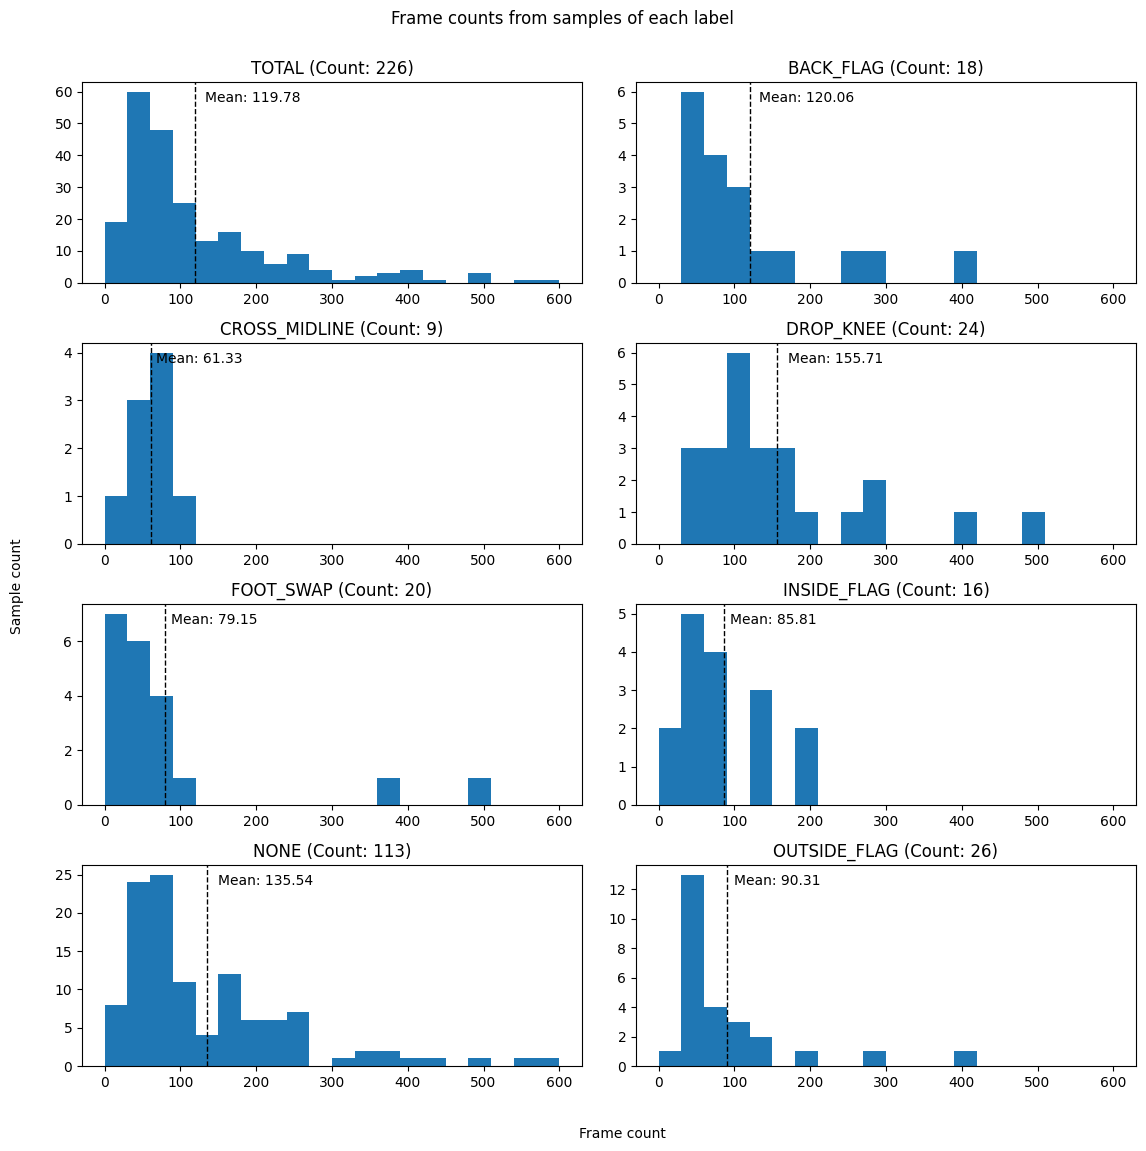

In [4]:
from sampling.images import plot_frame_count_distributions

samples_root_dir = "../data/samples"

plot_frame_count_distributions(samples_root_dir)
